In [1]:
import tensorflow as tf
import os
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from nilearn import image
from nilearn import plotting
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = '/local-scratch/localhome/mkhademi/BOLD5000_2.0/'
batch_size = 20
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_coco.tfrecords']).batch(batch_size)
train_ds = dataset.take(1800//batch_size)
test_ds = dataset.skip(1800//batch_size)
test_ds = test_ds.take(200//batch_size)
train_ds = train_ds.shuffle(1800)

In [3]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'y': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12), dtype=tf.int64),
            'y_face': tf.io.FixedLenFeature(shape=(2), dtype=tf.int64),
        })
    return example['x'], example['y_face']
    
decoded = train_ds.map(tf_parse)
decoded_test = test_ds.map(tf_parse)

In [4]:
raw_example = next(iter(test_ds))
print(tf_parse(raw_example)[0].numpy().shape)
print(tf_parse(raw_example)[1].numpy().shape)
print(tf_parse(raw_example)[1].numpy().sum(axis=1))

(20, 71, 89, 72, 1)
(20, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
for x_batch, y_batch in decoded_test.take(1):
    print(x_batch.shape, y_batch.shape)

(20, 71, 89, 72, 1) (20, 2)


In [6]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(71, 89, 72, 1)),
    tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
    # tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv2'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
    # tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv3'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    # tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(2),
    #tf.keras.layers.Softmax()
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten (Flatten)            (None, 26928)             0         
_________________________________________________________________
dropout (Dropout)            (None, 26928)             0

In [7]:
model.compile(
    # loss='mse',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # optimizer=keras.optimizers.RMSprop(),
    optimizer='adam',
    # metrics=[tf.keras.metrics.MeanSquaredError()],
    
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)
model.fit(decoded, epochs=60)

Epoch 1/60
90/90 [==============================] - 17s 133ms/step - loss: 60.0545 - categorical_accuracy: 0.6300
Epoch 2/60
90/90 [==============================] - 14s 133ms/step - loss: 52.2871 - categorical_accuracy: 0.6261
Epoch 3/60
90/90 [==============================] - 14s 135ms/step - loss: 41.3345 - categorical_accuracy: 0.6611
Epoch 4/60
90/90 [==============================] - 15s 135ms/step - loss: 18.7607 - categorical_accuracy: 0.6922
Epoch 5/60
90/90 [==============================] - 14s 135ms/step - loss: 11.1688 - categorical_accuracy: 0.6961
Epoch 6/60
90/90 [==============================] - 14s 135ms/step - loss: 12.0497 - categorical_accuracy: 0.7144
Epoch 7/60
90/90 [==============================] - 15s 138ms/step - loss: 9.4657 - categorical_accuracy: 0.7189
Epoch 8/60
90/90 [==============================] - 15s 139ms/step - loss: 6.5956 - categorical_accuracy: 0.7256
Epoch 9/60
90/90 [==============================] - 15s 136ms/step - loss: 6.4119 - catego

In [8]:
img4d = image.load_img(data_dir + 'CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz');
selected_volumes = image.index_img(img4d, slice(200, 201))
imgs = [img for img in image.iter_img(selected_volumes)]
img = imgs[0]
mask = np.zeros(img.shape) * image.get_data(img)
# plot_stat_map(img, threshold='auto', display_mode="z", cut_coords=4, bg_img=None)

In [9]:
for x_batch, y_batch in decoded_test.take(1):
    pass
x_var = tf.Variable(x_batch, dtype=tf.float32)

with tf.GradientTape() as tape0:
    preds0 = model(x_var)[:,0]
print(preds0.shape)
grads0 = tape0.gradient(preds0, x_var)
print(grads0.numpy().shape)
print(grads0.numpy().sum())

with tf.GradientTape() as tape1:
    preds1 = model(x_var)[:,1]
print(preds1.shape)
grads1 = tape1.gradient(preds1, x_var)
print(grads1.numpy().shape)
print(grads1.numpy().sum())

with tf.GradientTape() as tape:
    preds = model(x_var)
batch_jacobian = tape.batch_jacobian(preds, x_var)
print(batch_jacobian.numpy().shape)
print(batch_jacobian.numpy()[:,0,:,:,:,:].sum())
print(batch_jacobian.numpy()[:,1,:,:,:,:].sum())

@tf.function
def f(x_batch):
    with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_batch)
            preds = model(x_batch)
    batch_jacobian = tape.batch_jacobian(preds, x_batch)
    return batch_jacobian

(20,)
(20, 71, 89, 72, 1)
-13.55785
(20,)
(20, 71, 89, 72, 1)
23.153414
(20, 2, 71, 89, 72, 1)
-13.557856
23.153416


/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


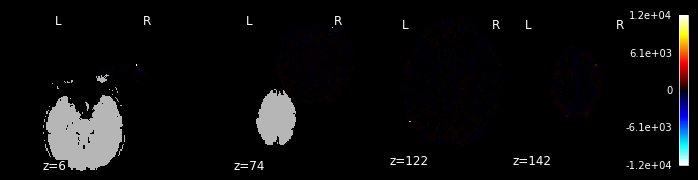

In [10]:
brain_mask = image.load_img(data_dir + 'CSI1_brainmask.nii.gz');
plot_stat_map(img, threshold='auto', display_mode="z", cut_coords=4, bg_img=brain_mask)

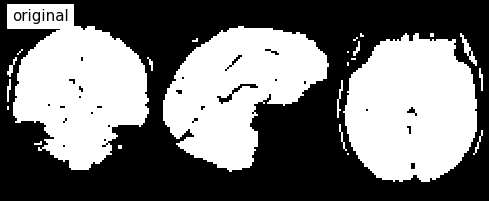

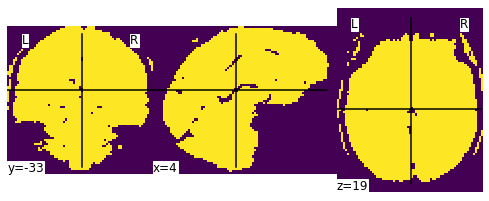

In [11]:
anat = data_dir + 'CSI1_brainmask.nii.gz'  
plot_anat(anat, title='original', display_mode='ortho', dim=-1, draw_cross=False, annotate=False)
plot_img(anat)

In [12]:
from nilearn import datasets
print('Datasets are stored in: %r' % datasets.get_data_dirs())
motor_images = datasets.fetch_neurovault_motor_task()
motor_images.images
tmap_filename = motor_images.images[0]
# plot_stat_map(tmap_filename)
# plot_stat_map(tmap_filename, threshold=3)

Datasets are stored in: ['/localhome/mkhademi/nilearn_data']


In [13]:
img_data = np.array(img.dataobj)
print(np.max(img_data))
print(np.min(img_data))

9611.976
-12267.824


In [14]:
vis_output = model.get_layer('conv2').output
print(vis_output.shape)
vis_model = tf.keras.models.Model(inputs=model.input, outputs=vis_output)
vis_face = np.zeros(vis_output.shape[1:4])
vis_noface = np.zeros(vis_output.shape[1:4])
count_face = 0
count_noface = 0
for x_batch, y_batch in decoded:
    output = vis_model.predict(x_batch)
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            vis_face += output[i][:,:,:,0] 
            count_face += 1
        else:
            vis_noface += output[i][:,:,:,0]
            count_noface += 1
                      
print(count_face)
print(count_noface)
vis_face = vis_face/count_face 
vis_noface = vis_noface/count_noface 
# print(vis_face) 
print(np.max(vis_face))
print(np.min(vis_face))

(None, 71, 89, 72, 2)
470
1330
301.87857218955423
0.0


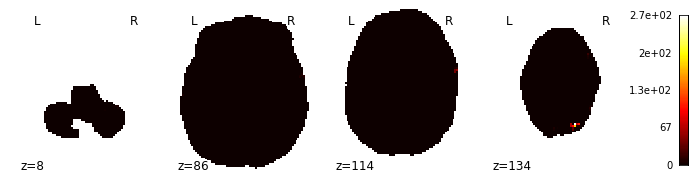

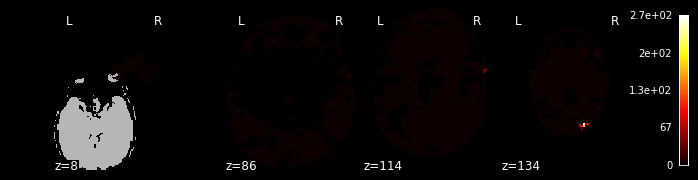

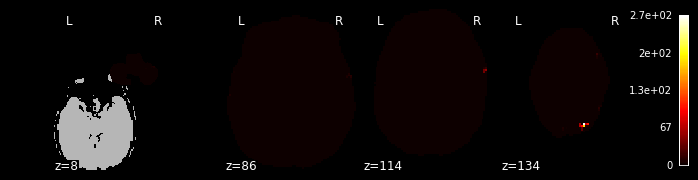

In [15]:
vis_face += mask
vis_noface += mask

nifti_file = nib.nifti1.Nifti1Image(dataobj=vis_face, affine=img.affine, header=img.header, extra=None, file_map=None)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=None)

plot_stat_map(nifti_file, threshold='auto', display_mode="z", cut_coords=4, bg_img=brain_mask)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=brain_mask)

In [16]:
vis_face = np.zeros(x_batch.shape[1:4])
vis_noface = np.zeros(x_batch.shape[1:4])
count_face = 0
count_noface = 0
for x_batch, y_batch in decoded:
    batch_jacobian = f(x_batch) # (20, 2, 71, 89, 72, 1)
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            vis_face += np.absolute(batch_jacobian.numpy()[i,0,:,:,:,0]) 
            count_face += 1
        else:
            vis_noface += np.absolute(batch_jacobian.numpy()[i,1,:,:,:,0])
            count_noface += 1
print(count_face)
print(count_noface)
vis_face = vis_face/count_face 
vis_noface = vis_noface/count_noface 
# print(vis_face) 
print(np.max(vis_face))
print(np.min(vis_face))

470
1330
0.007218004135892384
0.0


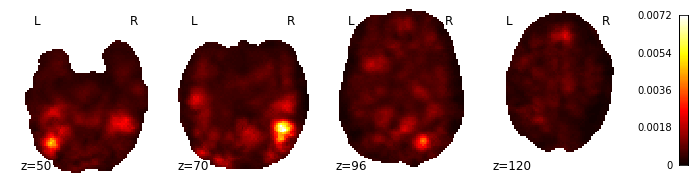

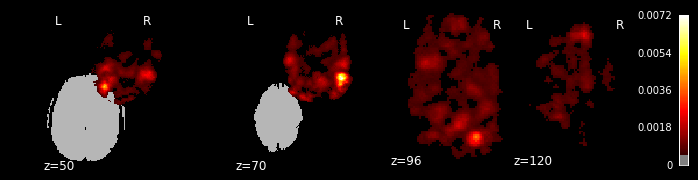

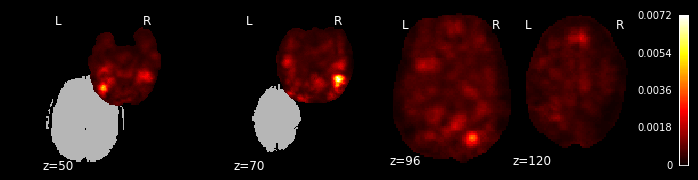

In [17]:
vis_face += mask
vis_noface += mask

nifti_file = nib.nifti1.Nifti1Image(dataobj=vis_face, affine=img.affine, header=img.header, extra=None, file_map=None)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=None)

plot_stat_map(nifti_file, threshold='auto', display_mode="z", cut_coords=4, bg_img=brain_mask)
plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=brain_mask)

In [18]:
model.evaluate(decoded_test)

10/10 [==============================] - 4s 49ms/step - loss: 0.7950 - categorical_accuracy: 0.7650


[0.7949874997138977, 0.7649999856948853]

In [19]:
model.add(tf.keras.layers.Softmax())
m_recall = tf.keras.metrics.Recall()
m_auc = tf.keras.metrics.AUC()
for x_batch, y_batch in decoded_test:
    yhat = model(x_batch)
    m_recall.update_state(y_batch, yhat)
    m_auc.update_state(y_batch, yhat)
print("Recall:", m_recall.result().numpy())
print("AUC:", m_auc.result().numpy())

pos = 0
neg = 0
for x_batch, y_batch in decoded_test:
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            pos += 1
        else:
            neg += 1
print(pos)
print(neg)

Recall: 0.765
AUC: 0.8175125
50
150


In [20]:
batch_size = 20
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_common.tfrecords']).batch(batch_size)
train_ds = dataset.take((2135+400)//batch_size)
test_ds = dataset.skip((2135+400)//batch_size)
test_ds = test_ds.take(329//batch_size)
train_ds = train_ds.shuffle(2135+400)

In [21]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'y': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12), dtype=tf.int64),
            'y_face': tf.io.FixedLenFeature(shape=(2), dtype=tf.int64),
        })
    return example['x'], example['y_super']
    
decoded = train_ds.map(tf_parse)
decoded_test = test_ds.map(tf_parse)

In [22]:
raw_example = next(iter(test_ds))
print(tf_parse(raw_example)[0].numpy().shape)
print(tf_parse(raw_example)[1].numpy().shape)
print(tf_parse(raw_example)[1].numpy().sum(axis=1))

(20, 71, 89, 72, 1)
(20, 12)
[1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1]


In [23]:
for x_batch, y_batch in decoded_test.take(1):
    print(x_batch.shape)

(20, 71, 89, 72, 1)


In [24]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(71, 89, 72, 1)),
    tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
    # tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(2, 3, padding='same', name='conv2'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
    # tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv3'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(12, activation='sigmoid'),
    # tf.keras.layers.Softmax()
    ])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26928)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26928)            

In [25]:
model.compile(
    # loss='mse',
    # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # optimizer=keras.optimizers.RMSprop(),
    optimizer='adam',
    # metrics=[tf.keras.metrics.MeanSquaredError()],
    # metrics=[tf.keras.metrics.CategoricalAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)
#model.fit(decoded, epochs=60)

In [26]:
loss, accuracy = model.evaluate(decoded_test)

16/16 [==============================] - 4s 47ms/step - loss: 13.4523 - binary_accuracy: 0.4589


In [27]:
for x_batch, y_batch in decoded_test.take(1):
    #print(tf.keras.activations.sigmoid(model(x_batch)))
    print(model(x_batch))

tf.Tensor(
[[5.75550896e-09 4.01439916e-17 9.99022603e-01 9.32953829e-21
  9.87631977e-01 9.76930737e-01 5.07380610e-05 1.00000000e+00
  8.98910224e-01 1.00000000e+00 9.99976516e-01 9.99998212e-01]
 [2.58072278e-17 5.10192294e-05 1.00000000e+00 4.44259562e-09
  3.14487010e-01 3.90404018e-13 1.00000000e+00 1.13735186e-05
  1.00000000e+00 1.00000000e+00 9.99972224e-01 2.07934365e-01]
 [9.63106474e-26 1.22624556e-06 9.99760687e-01 1.70880331e-15
  9.60886665e-03 3.84595508e-17 3.51614737e-08 9.99597847e-01
  2.46142008e-04 1.00000000e+00 1.00000000e+00 7.29069650e-01]
 [1.20237332e-19 1.44174468e-04 9.99999404e-01 5.26858800e-11
  4.93123941e-03 2.18005127e-07 1.58416631e-11 1.00000000e+00
  2.29008194e-07 1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [2.52139525e-11 2.08774491e-05 1.00000000e+00 9.17179696e-03
  1.00000000e+00 2.71865865e-20 1.62718609e-01 1.00000000e+00
  9.98948634e-01 1.00000000e+00 9.99999642e-01 1.00000000e+00]
 [0.00000000e+00 1.08967178e-15 1.00000000e+00 1.17439